<a href="https://colab.research.google.com/github/rujuldwivedi/Internship/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [3]:
# Declare the file path
file_path = '/content/drive/My Drive/Internship/sampled_dataset.csv'

In [4]:
# Load dataset
data = pd.read_csv(file_path)

# Sample the data
data = data.sample(frac=0.1, random_state=10)

In [5]:
# Display basic information
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 32480 entries, 37538 to 160665
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   main_category  32480 non-null  object
 1   title          32480 non-null  object
 2   description    32480 non-null  object
 3   images         32480 non-null  object
 4   details        32480 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB
                    main_category  \
37538   Cell Phones & Accessories   
124693               Toys & Games   
249067                Amazon Home   
103904   Tools & Home Improvement   
126448  Cell Phones & Accessories   

                                                    title  \
37538   Galaxy S8 Active Case - R2D2 Droid Robot Patte...   
124693  Magic: the Gathering - Arcbound Lancer - Darks...   
249067  Fall Harvest Sitting Scarecrow with Dangling L...   
103904  Leviton 80530-BLK EB WP 2G POWER OUTLET 2,465 ...   
126448  Alcatel Idol 4s

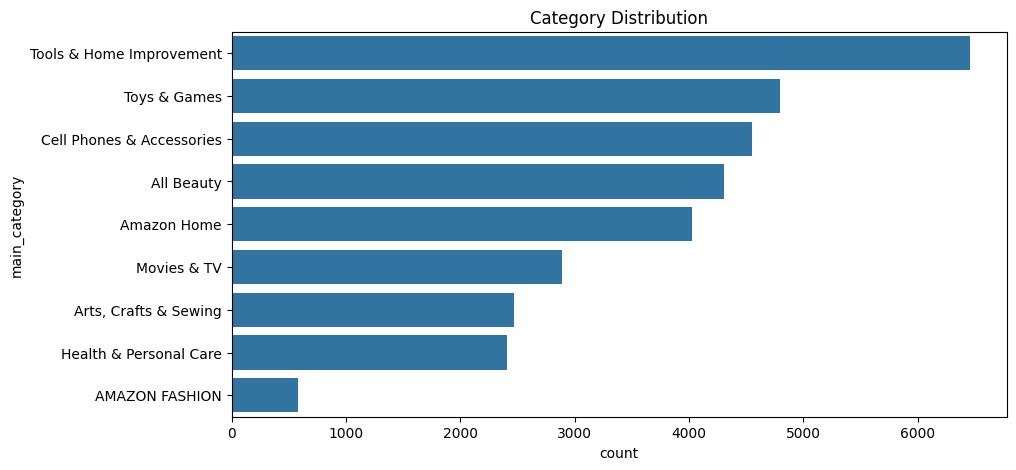

In [6]:
# EDA: Category distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=data['main_category'], order=data['main_category'].value_counts().index)
plt.title('Category Distribution')
plt.show()

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

data['processed_text'] = data['title'] + ' ' + data['description']
data['processed_text'] = data['processed_text'].apply(clean_text)

In [9]:
# Tokenization & Vectorization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [10]:
# Label Encoding
category_mapping = {category: idx for idx, category in enumerate(data['main_category'].unique())}
data['category_encoded'] = data['main_category'].map(category_mapping)
y = to_categorical(data['category_encoded'])

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [12]:
# LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(len(category_mapping), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 150s 358ms/step - accuracy: 0.4569 - loss: 1.5368 - val_accuracy: 0.8157 - val_loss: 0.6112
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 198s 349ms/step - accuracy: 0.8383 - loss: 0.5477 - val_accuracy: 0.8724 - val_loss: 0.4520
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 146s 360ms/step - accuracy: 0.8928 - loss: 0.3717 - val_accuracy: 0.8867 - val_loss: 0.4049
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 203s 362ms/step - accuracy: 0.9202 - loss: 0.2932 - val_accuracy: 0.8802 - val_loss: 0.4280
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 202s 364ms/step - accuracy: 0.9289 - loss: 0.2517 - val_accuracy: 0.8919 - val_loss: 0.4105


In [13]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

203/203 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.8925 - loss: 0.4215
Test Accuracy: 89.19%


In [22]:
# Test the model with a new description
new_description = 'Unveil a radiant, youthful complexion with our luxurious Elixir of Youth serum, a potent blend of hyaluronic acid and vitamin C that deeply hydrates, visibly plumps fine lines, and brightens skin tone for a rejuvenated appearance. Experience the silky smooth texture that absorbs instantly, leaving your face feeling refreshed and glowing with a healthy radiance.'
new_description = clean_text(new_description)
new_sequence = tokenizer.texts_to_sequences([new_description])
new_padded_sequence = pad_sequences(new_sequence, maxlen=100)
prediction = model.predict(new_padded_sequence)
predicted_category = data['main_category'].unique()[np.argmax(prediction)]
print(f'Predicted Category: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Category: All Beauty


In [24]:
# Save the model
model.save('product_category_model.keras')

In [25]:
# Save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# Save the category mapping
with open('category_mapping.pickle', 'wb') as handle:
    pickle.dump(category_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('product_category_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [29]:
# Load the category mapping
with open('category_mapping.pickle', 'rb') as handle:
    category_mapping = pickle.load(handle)

In [32]:
# Test the loaded model with a new description
new_description = "The action-packed 'Mission Impossible - Dead Reckoning' features Tom Cruise performing death-defying stunts while prominently driving a sleek new BMW motorcycle, showcasing the brand's high-performance capabilities."
new_description = clean_text(new_description)
new_sequence = tokenizer.texts_to_sequences([new_description])
new_padded_sequence = pad_sequences(new_sequence, maxlen=100)
prediction = model.predict(new_padded_sequence)
predicted_category = list(category_mapping.keys())[np.argmax(prediction)]
print(f'Predicted Category: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Category: Movies & TV
